In [1]:
import heeps
from heeps.util.img_processing import resize_img
from heeps.util.coord import cart_coord
import matplotlib.pyplot as plt
import os.path
from astropy.io import fits
%matplotlib inline

## Input parameters

In [55]:
npupil = 285
nimg = 2**10
pupil_img_size = 39.9988
ax, ay = (-14.642, -55.812) # A0
bx, by = (  0.739, -75.899) # B2
cx, cy = (  5.691, -65.735) # C1
dx, dy = ( 15.628, -45.397) # D0
AT_rad = 1.8/2              # AT radius
AT_rot = -8.5                # AT rotation in deg
folder = '/Users/cdelacroix/heeps_metis/input_files/wavefront'
scao = 'cube_Cbasic_20210322_6000s_100ms_0piston_meters_scao_only_285_WVseeing.fits'
mask = 'mask_Cbasic_20210322_285.fits'

## AT coordinates

In [34]:
# find circumcenter and translate
d = 2 * (ax * (by - dy) + bx * (dy - ay) + dx * (ay - by))
ux = ((ax**2 + ay**2) * (by - dy) + (bx**2 + by**2) * (dy - ay) + (dx**2 + dy**2) * (ay - by)) / d
uy = ((ax**2 + ay**2) * (dx - bx) + (bx**2 + by**2) * (ax - dx) + (dx**2 + dy**2) * (bx - ax)) / d
ATs = np.array([[ax, ay], [bx, by], [cx, cy], [dx, dy]]) - [ux, uy]
# rotate to fit in ELT M1
t = np.deg2rad(AT_rot)
ATs = np.array([(x*np.cos(t) - y*np.sin(t), x*np.sin(t) + y*np.cos(t)) for x,y in ATs])
print('AT coords:\n%s'%ATs)

AT coords:
[[-17.19345442   4.94727687]
 [ -4.95044907 -17.19254133]
 [  1.44949234  -7.8721363 ]
 [ 14.28349078  10.77368621]]


## Create subapertures

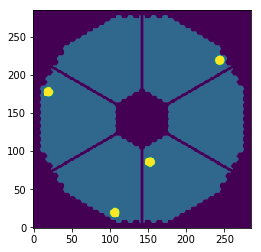

In [44]:
XY = np.array(cart_coord(nimg), ndmin=4)*pupil_img_size/2
XY = (XY.T - ATs.T).T
R = np.abs(XY[:,0] + 1j*XY[:,1])
R = (R <= AT_rad).astype(int)
aper = resize_img(R, npupil)
pup = fits.getdata(os.path.join(folder, mask))
aper_ATs = np.sum(aper, 0) + pup/2
plt.imshow(aper_ATs, origin=True)
fits.writeto(os.path.join(folder, 'aper_ATs.fits'), np.float32(aper_ATs), overwrite=True)

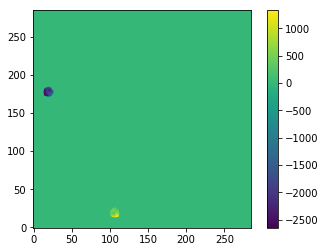

In [62]:
cube = fits.getdata(os.path.join(folder, scao))*1e9
base1 = aper[0]+aper[1]
cube1 = base1*cube
plt.imshow(cube1[0], origin=True), plt.colorbar();

In [65]:
rms = [np.std(np.mean((aper[0]-aper[1])*cube, 0)),
       np.std(np.mean((aper[0]-aper[2])*cube, 0)),
       np.std(np.mean((aper[0]-aper[3])*cube, 0)),
       np.std(np.mean((aper[1]-aper[2])*cube, 0)),
       np.std(np.mean((aper[1]-aper[3])*cube, 0)),
       np.std(np.mean((aper[2]-aper[3])*cube, 0))]

In [66]:
rms

[9.689676, 5.169246, 6.6856537, 9.444677, 10.351116, 6.353089]